Steller Hosts Data

All data from NASAs Steller Hosts database DOI: 10.26133/NEA40

In [1]:
from astroquery.utils.tap.core import TapPlus
from io import StringIO
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# check the schema of the data, as there are 134 columns I've saved the data as a csv file for easier referal/reading to see what data I would like to work with
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT * FROM TAP_SCHEMA.columns WHERE table_name LIKE 'stellarhosts'"
job = tap_service.launch_job(query)

result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts_schema = pd.read_csv(StringIO(result_csv))
stellar_hosts_schema.to_csv('stellar_hosts_schema.csv', index=False)

In [3]:
# make spefic query for the specific columns wanted 
tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
query = "SELECT sy_name, sy_snum, sy_pnum, sy_mnum, cb_flag, st_spectype FROM stellarhosts"
job = tap_service.launch_job_async(query)

# save stellar_hosts as dataframe and file for reference 
result_csv = job.get_results().to_pandas().to_csv(index=False)
stellar_hosts = pd.read_csv(StringIO(result_csv))
stellar_hosts.to_csv('stellar_hosts.csv', index=False)

INFO: Query finished. [astroquery.utils.tap.core]


The database that is being searched is a list of planets and suns within star systems in the universe.
The question we're intrested is simple for the sake of learning, how does the frequency of stars in a system affect the frequency of planets, if it does at all? Since I have also added the cb_flag an int value where 0 = false and 1 = true inrelation to if the planet orbits a binary star system (this data may or may not be used). 

To answer this question we have searched the NASA archives via TAP (table access protocol) to gather the schema from stellar hosts, as we knew this is the database we wanted to access in advance, otherwise we could have made a query which would have returned what tables we could access and chosen from there.
    Once we have the TAP set up for the table we want to query, we can create a query variable which is a SQL string, then we launch a job which runs the query on the Tap service. The results of the query need to be converted into a csv file as the default is returned as a VOTable file. Then we need to read the csv file into a pandas dataframe. I also created a csv file for debugging purposes as working with these libraries and with data is new to me.

In [4]:
# tap_service = TapPlus(url="https://exoplanetarchive.ipac.caltech.edu/TAP")
# query = "SELECT count(sy_name) FROM stellarhosts"
# job = tap_service.launch_job_async(query)

# result_csv = job.get_results().to_pandas().to_csv(index=False)
# stellar_hosts_count = pd.read_csv(StringIO(result_csv))
# stellar_hosts_count

The above was made as a test script, as I was only getting 2000 rows back from my stellar hosts database, the perfectly rounded number was suspicious and I checked the online database to find that there should be over 4000 rows of data. I thought that by getting the Tap query to return the count of rows I could see the amount of data I should be receiving but instead I was also being returned with a 2000 count, so it appeared that the amount of returned rows wasn't an issue, but the process itself. I did some searching online and returned to a reference on NASA's site regarding Synchronous and Asynchronous queries, I had assumed that it was file sized and assumed that the automatic synchronous search would be adequate. But I was incorrect and changed the launch_job to launch_job_async and now was receiving all of the data from the database with the data I required.    

In [5]:
# check dataframe
stellar_hosts

,sy_name,sy_snum,sy_pnum,sy_mnum,cb_flag,st_spectype
0,MOA-2010-BLG-117L,1,1,0,0,NaN
1,Kepler-914,1,1,0,0,NaN
2,HD 62509,1,1,0,0,K0IIIvar
3,alf Cen,3,1,0,0,NaN
4,Kepler-79,1,4,0,0,NaN
...,...,...,...,...,...,...
44874,TOI-1173,2,1,0,0,NaN
44875,WASP-156,1,1,0,0,NaN
44876,TOI-1173,2,1,0,0,NaN
44877,51 Eri,3,1,0,0,NaN


The above is a truncated print out of the stellar_hosts dataframe created from the NASA database to get a preview of the dataframe.

From the stellar_hosts data frame we can see that there is a lot of NaN values from st_spectype so lets see how many null variables there are in this data type...

In [6]:
stellar_hosts.isnull().sum()

sy_name            0
sy_snum            0
sy_pnum            0
sy_mnum            0
cb_flag            0
st_spectype    41702
dtype: int64

The isnull sum is extremely high in relation to the amount of data that we have.

In [7]:
stellar_hosts = stellar_hosts.dropna(axis=1)

As this particular data is not important for the question we are trying to answer, I am happy for the purposes of this test to drop this column. axis 1 refers to a column where as axis = 0 would have dropped any rows that na values in the st_spectype (star spectra type) and we don't want to get rid of all the rows just the column of data which is not required for our data. 

After executing the code above we can re-run the 'stellar_hosts' code to check that the data has been dropped.

In [8]:
stellar_hosts = stellar_hosts.sort_values(by=['sy_name'])

We can sort the systems by alphanumeric names (by personal choice)

In [9]:
stellar_hosts.groupby(stellar_hosts.cb_flag > 0).sy_name.count()

cb_flag
False    44585
True       294
Name: sy_name, dtype: int64

We can see that from the truncated data there is a lot of 0's in the output of cb_flag (Circumbinary Flag - where there is a binary star system), so the above code lets us see how many systems contain a binary star sytem if any.

In [10]:
# check for moons in systems
stellar_hosts.groupby(stellar_hosts.sy_mnum > 0).sy_name.count()

sy_mnum
False    44879
Name: sy_name, dtype: int64

The truncated dataframe also showed a lot of 0 values for sy_mnum (moons in the system) so lets see how many verified moons there are.
As we can see from running the code above, none of these systems have been recorded as containing moons, as all systems return false when grouped by containing atleast 1 moon. As this data isn't important for the question I want to answer I am happy to remove the series from the dataframe.

In [11]:
stellar_hosts = stellar_hosts.drop('sy_mnum', axis = 1)

The sy_mnum column has been dropped from the stellar_hosts database, lets run the 'stellar_hosts' code in one of the previous nodes to make sure it worked.

In [12]:
#stellar_hosts.duplicated()
stellar_hosts = stellar_hosts.drop_duplicates()
stellar_hosts.sy_name.count().sum()
stellar_hosts.to_csv('stellar_hosts_data.csv', index=False)

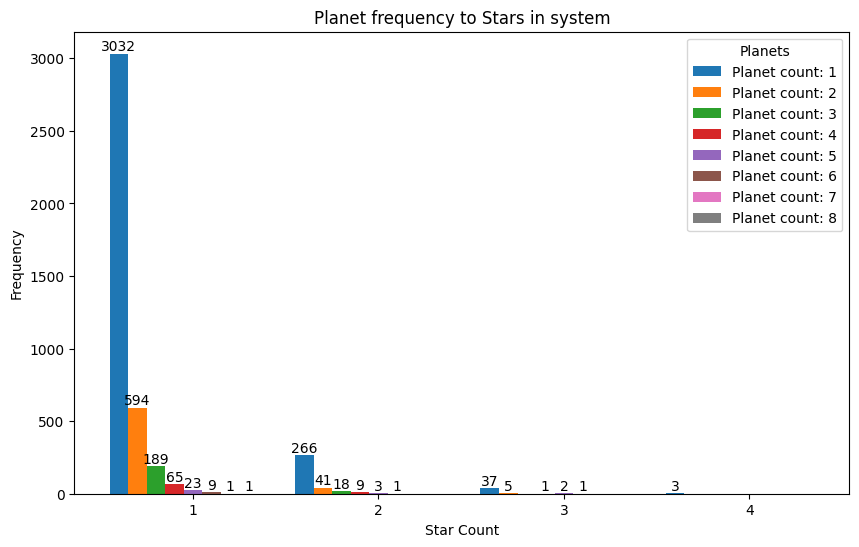

In [13]:
stellar_df = pd.DataFrame(stellar_hosts)

grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
indices = np.arange(len(grouped))

for i, sy_pnum_val in enumerate(grouped.columns):
    bars = ax.bar(indices + i * bar_width, grouped[sy_pnum_val], bar_width, label=f'Planet count: {sy_pnum_val}')

    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

ax.set_xlabel('Star Count')
ax.set_ylabel('Frequency')
ax.set_title('Planet frequency to Stars in system')
ax.set_xticks(indices + bar_width * 4)
ax.set_xticklabels(grouped.index)
ax.legend(title='Planets')

plt.show()

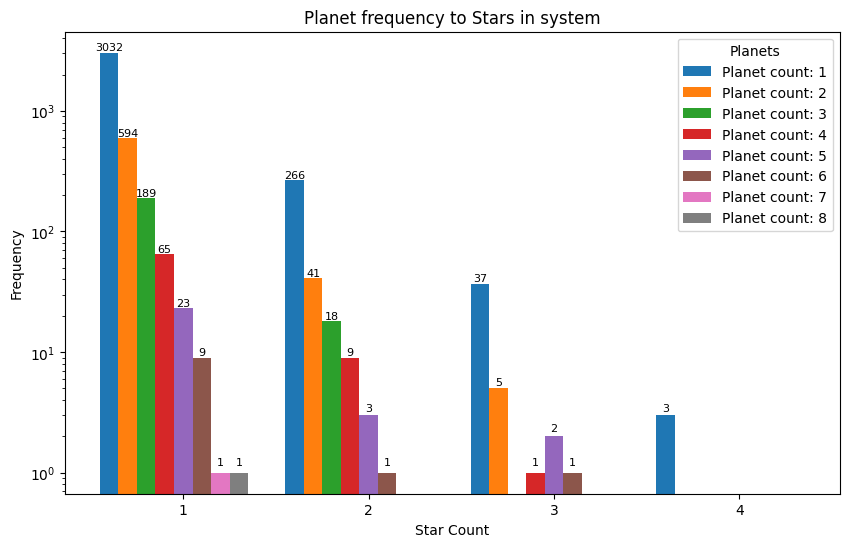

In [14]:
stellar_df = pd.DataFrame(stellar_hosts)

grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
indices = np.arange(len(grouped))

for i, sy_pnum_val in enumerate(grouped.columns):
    bars = ax.bar(indices + i * bar_width, grouped[sy_pnum_val], bar_width, label=f'Planet count: {sy_pnum_val}')

    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=8)

ax.set_yscale('log')

ax.set_xlabel('Star Count')
ax.set_ylabel('Frequency')
ax.set_title('Planet frequency to Stars in system')
ax.set_xticks(indices + bar_width * 4)
ax.set_xticklabels(grouped.index)
ax.legend(title='Planets')

plt.show()

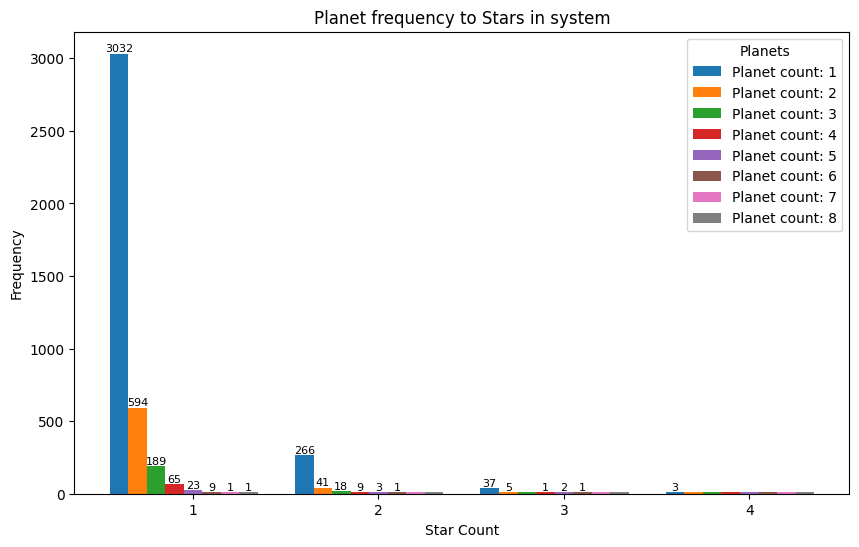

In [15]:
stellar_df = pd.DataFrame(stellar_hosts)

grouped = stellar_df.groupby(['sy_snum', 'sy_pnum']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.1
indices = np.arange(len(grouped))

min_display_height = 10

for i, sy_pnum_val in enumerate(grouped.columns):
    bars = ax.bar(indices + i * bar_width, grouped[sy_pnum_val].apply(lambda x: max(x, min_display_height)), bar_width, label=f'Planet count: {sy_pnum_val}')

    for bar, actual_value in zip(bars, grouped[sy_pnum_val]):
        yval = bar.get_height()
        if actual_value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(actual_value), ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Star Count')
ax.set_ylabel('Frequency')
ax.set_title('Planet frequency to Stars in system')
ax.set_xticks(indices + bar_width * 4)
ax.set_xticklabels(grouped.index)
ax.legend(title='Planets')

plt.show()

Above we are re-moving duplicate data from the dataframe, as NASA's Stellar Hosts rows may contain information on various stellar bodies, we only want the individual system information which is duplicated for each row of a stellar body within a system, for this reason we are removing any data which is duplicated and will drastically reduce the data we are working from as many systems have atleast one star and planet which effecitvely doubles the data in this instance alone. To reduce duplicate data we need to remove these.
    stellar_hosts.sy_name.count().sum() allows us the see the amount of rows now in our dataframe which is drastically different from what we started with.

In [16]:
star = stellar_hosts.sy_snum.max()
planet = stellar_hosts.sy_pnum.max()

p_to_s_freq_df = pd.DataFrame(columns=['star_planet_count', 'frequency'])

# index counter for writing the frequency dataframe
x = 0
i = 1
# iterate over possible star counts
while i < star + 1:
    # set to 0 and iterate over possible planet counts
    j = 1
    while j < planet + 1:
        # make the star count == to star iteration & make planet count == to planet count itteration
        ss_df = stellar_hosts[(stellar_hosts['sy_snum'] == i) & (stellar_hosts['sy_pnum'] == j)]
        # add the count of occurances to count
        count = len(ss_df)
        if count > 0:
            p_to_s_freq_df.loc[x] = [str(i) + 'Stars ' + str(j) + 'Planets', count]
            x += 1
        # write into data frame making the reference == the star and planet count and setting the frequency to the counter
        j += 1
    i += 1

p_to_s_freq_df.to_csv('p_to_s_freq_df.csv', index=False)

Here we are iterating over the data with a nested loop, the first loop is in relation to the count of stars and the second is in relation to the count of planets. These iterative values are used so that we can see for each count of planets how often they are found within a system with each count of planets. Then the frequency in which each of these cases occurs is added into a new frequency dataframe with the star and planet count referenced in the name for data reference. As there are many counts of star systems that may contain no planets if the frequency is 0 the series will not be added to the new dataframe and the data will be left out (this is by choice but can easily be represented if desired for visual reasons).

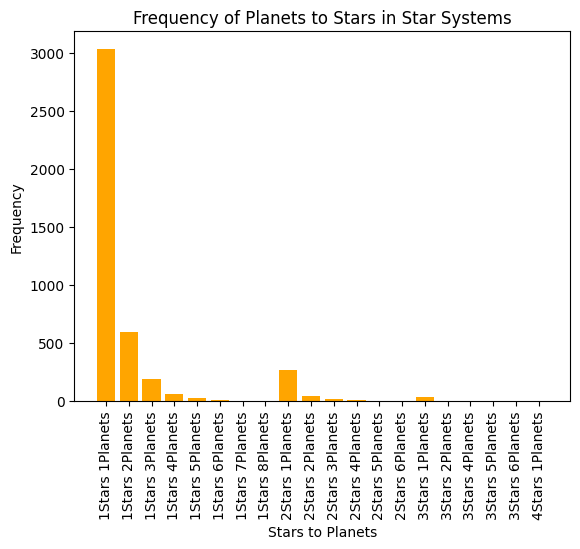

In [17]:
plt.bar(x=p_to_s_freq_df.star_planet_count, height=p_to_s_freq_df.frequency, color="orange")

plt.title("Frequency of Planets to Stars in Star Systems")
plt.xlabel("Stars to Planets")
plt.ylabel("Frequency")
plt.xticks(rotation=90)

plt.show()

In [18]:
# check the comonality of those being binary star systems


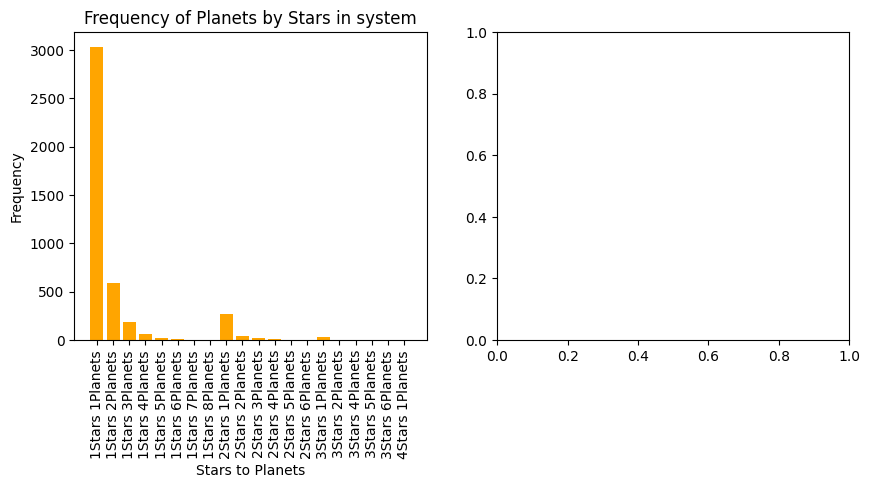

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(x=p_to_s_freq_df.star_planet_count, height=p_to_s_freq_df.frequency, color="orange")
lable = p_to_s_freq_df.star_planet_count
ax[0].set_title("Frequency of Planets by Stars in system")
ax[0].set_xlabel("Stars to Planets")
ax[0].set_ylabel("Frequency")
# found how to rotate figure labels from stackoverflow 
for label in ax[0].get_xticklabels():
    label.set_rotation(90)

#ax[1].boxplot(sy_planet)